# Инфраструктура для моделей машинного обучения. Практическая работа

# Цель практической работы

Потренироваться в использовании библиотек PySpark SQL и PySpark ML для предобработки данных и обучения моделей.

# Что входит в практическую работу

1. Инициализация спарк-сессии.
2. Загрузка данных.
3. Ознакомление с данными.
4. Преобразование типов столбцов.
5. Очистка данных.
6. Feature-инжиниринг.
7. Векторизация фичей.
8. Создание и обучение модели.
9. Выбор лучшей модели.
10. Обратная связь.


# Что оценивается

- Пройдены все этапы работы.
- Спарк-сессия успешно запущена.
- Данные прочитаны.
- Все колонки с числовыми значениями преобразованы в числовые типы данных (Int или Double).
- Отфильтрованы все строки с Null-значениями.
- Созданы новые фичи.
- Все категориальные колонки преобразованы в числовой вид, выполнены все этапы векторизации признаков.
- Выборка разделена на обучающую и тестовую.
- Создано три объекта: модель, сетка гиперпараметров и evaluator.
- Создан объект класса CrossValidator и обучен на обучающей выборке.
- Выбрана лучшая модель, посчитана метрика качества лучшей модели.


# Задача

Используя данные о клиентах телекоммуникационной компании, обучите модель, предсказывающую их отток.

Описание данных, с которыми вы будете работать:

* **CustomerID**: ID клиента.
* **Gender**: пол клиента.
* **SeniorCitizen**: пенсионер ли клиент (1 — да, 0 — нет).
* **Partner**: есть у клиента партнёр (жена, муж) или нет (Yes/No).
* **Dependents**: есть ли у клиента инждивенцы, например дети (Yes/No).
* **Tenure**: как много месяцев клиент оставался в компании.
* **PhoneService**: подключена ли у клиента телефонная служба (Yes/No).
* **MultipleLines**: подключено ли несколько телефонных линий (Yes, No, No phone service).
* **InternetService**: интернет-провайдер клиента (DSL, Fiber optic, No).
* **OnlineSecurity**: подключена ли у клиента услуга онлайн-безопасности (Yes, No, No internet service)
* **OnlineBackup**: подключена ли услуга резервного копирования онлайн (Yes, No, No internet service).
* **DeviceProtection**: подключена ли услуга защиты устройства (Yes, No, No internet service)
* **TechSupport**: есть ли у клиента техническая поддержка (Yes, No, No internet service).
* **StreamingTV**: подключена ли услуга потокового телевидения (Yes, No, No internet service).
* **StreamingMovies**: подключена ли услуга стримингового воспроизведения фильмов (Yes, No, No internet service).
* **Contract**: тип контракта клиента (Month-to-month, One year, Two year).
* **PaperlessBilling**: есть ли безбумажный счёт.
* **PaymentMethod**: способ оплаты услуг (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)).
* **MonthlyCharges**: сумма, которая списывается ежемесячно.
* **TotalCharges**: сумма, списанная за всё время.
* **Churn**: ушёл ли клиент (Yes/No). Это целевая переменная, которую нужно предсказать.


# 1. Инициализация спарк-сессии

Инициализируйте спарк-сессию.

Эта ячейка нужна для того, чтобы заргузить необходимые библиотеки и настроить окружение Google Colab для работы со Spark.

Просто запустите её перед выполением задания :)

In [1]:
#!pip install pyspark --quiet
#!pip install -U -q PyDrive --quiet
#!apt install openjdk-8-jdk-headless &> /dev/null

#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip &> /dev/null
#!unzip ngrok-stable-linux-amd64.zip &> /dev/null
#get_ipython().system_raw('./ngrok http 4050 &')


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import col,sum,avg,max,count,expr, isnull
from pyspark.sql.functions import when 
from pyspark import mllib
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql import DataFrame
from pyspark.ml.linalg import Vector, Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import log
from pyspark.sql.types import StringType




In [3]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

24/09/18 19:26:33 WARN Utils: Your hostname, leons resolves to a loopback address: 127.0.1.1; using 192.168.1.106 instead (on interface wlp2s0)
24/09/18 19:26:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/18 19:26:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/18 19:26:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# 2. Загрузка данных
Загрузите данные, сохраните их в переменную типа sparkDataframe, используя метод read.csv (не забывайте про header и delimiter).

In [4]:
# !!! загрузим часть данных и посмотрим какой в данных разделитель
with open("data/WA_Fn-UseC_-Telco-Customer-Churn.csv", 'r') as f:
    for line in f.readlines()[:3]:  # Прочитаем первые 5 строк
        print(line)

# при несоответствующем разделителе получим пустую таблицу)))        

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn

7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No

5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No



In [5]:
realty = spark.read.option("header",True).option("delimiter",",").csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv") 

# 3. Ознакомление с данными
1. Выведите на экран первые несколько строк датафрейма.


In [6]:
print(type(realty)) #Смотрим тип переменной
realty.show(5)

<class 'pyspark.sql.dataframe.DataFrame'>
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|    


2. Выведите общее количество строк датафрейма.



In [7]:
realty.count()

7043

3. Выведите структуру (схему) датафрейма.

In [8]:
realty.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



# 4. Преобразование типов столбцов
Преобразуйте тип столбцов у числовых признаков (Int — если признак целочисленный, Double — если признак не целочисленный). Сохраните преобразованный датафрейм в новую переменную.

## Совет

Если вам сложно выполнить это задание, изучите дополнительные материалы: [об операторе Cast](https://sparkbyexamples.com/pyspark/pyspark-cast-column-type/), [об операторе Select](https://sparkbyexamples.com/pyspark/select-columns-from-pyspark-dataframe/).



In [9]:
realty_number = realty.select(
    col("SeniorCitizen").cast("Int"),
    col("tenure").cast("Int"),
    col("MonthlyCharges").cast("Double"),
    col("TotalCharges").cast("Double"),
)
#Мы выбрали из датафрейма колонки level, levels, rooms, area, kitchen_area, geo_lat, geo_lon, building_type, object_type, object_type, id_region, price,
#одновременно изменив их тип при помощи оператора cast(). Те колонки, которые мы не перечислили внутри Select, не попали в новый датафрейм realty_formatted.

In [10]:
realty_types = realty.select(
    col("customerID"),
    col("gender"),
    col("SeniorCitizen").cast("Int").alias("SeniorCitizen"),
    col("Partner"),
    col("Dependents"),
    col("tenure").cast("Int").alias("tenure"),
    col("PhoneService"),
    col("MultipleLines"),
    col("InternetService"),
    col("OnlineSecurity"),
    col("OnlineBackup"),
    col("DeviceProtection"),
    col("TechSupport"),
    col("StreamingTV"),
    col("StreamingMovies"),
    col("Contract"),
    col("PaperlessBilling"),
    col("PaymentMethod"),
    col("MonthlyCharges").cast("Double").alias("MonthlyCharges"),
    col("TotalCharges").cast("Double").alias("TotalCharges"),
    col("Churn")
)

In [11]:
realty_number.printSchema()

root
 |-- SeniorCitizen: integer (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)



In [12]:
realty_types.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



# 5. Очистка данных
Проверьте, есть ли в какой-либо колонке Null-значения. Для этого можно использовать your_dataframe.filter(col("colname")).isNull()).

Выведите на экран несколько строк с Null-значениями в одной из колонок.

Сохраните очищенный от строк с Null-значениями датафрейм в новую переменную. Для фильтрации этих значений можно использовать метод .isNotNull().

Колонок в датафрейме много, проверять каждую неудобно и долго. Подумайте, как упроситить эту работу, если использовать, например, перебор с циклом for.

[Примеры использования операторов isNull() и isNotNull()](https://sparkbyexamples.com/pyspark/pyspark-isnull/).


In [13]:
def count_missing_values(df):
    # Получаем список всех колонок
    columns = df.columns
    
    # Создаем список тюплов (имя колонки, количество пропущенных значений)
    missing_counts = []
    
    for column in columns:
        # Подсчитываем количество пропущенных значений в каждой колонке
        missing_count = df.filter(isnull(col(column))).count()
        missing_counts.append((column, missing_count))
    
    # Преобразуем в DataFrame для удобства отображения
    missing_values_df = spark.createDataFrame(missing_counts, ["Column", "MissingCount"])
    
    return missing_values_df

In [14]:
missing_values_result = count_missing_values(realty_types)

missing_values_result.show()

+----------------+------------+
|          Column|MissingCount|
+----------------+------------+
|      customerID|           0|
|          gender|           0|
|   SeniorCitizen|           0|
|         Partner|           0|
|      Dependents|           0|
|          tenure|           0|
|    PhoneService|           0|
|   MultipleLines|           0|
| InternetService|           0|
|  OnlineSecurity|           0|
|    OnlineBackup|           0|
|DeviceProtection|           0|
|     TechSupport|           0|
|     StreamingTV|           0|
| StreamingMovies|           0|
|        Contract|           0|
|PaperlessBilling|           0|
|   PaymentMethod|           0|
|  MonthlyCharges|           0|
|    TotalCharges|          11|
+----------------+------------+
only showing top 20 rows



In [15]:
missing_values_result = count_missing_values(realty_number)

missing_values_result.show()

+--------------+------------+
|        Column|MissingCount|
+--------------+------------+
| SeniorCitizen|           0|
|        tenure|           0|
|MonthlyCharges|           0|
|  TotalCharges|          11|
+--------------+------------+



In [16]:
def check_and_clean_nulls(dataframe):
    # Словарь для хранения колонок с Null-значениями
    null_columns = {}

    # Перебор всех колонок в датафрейме
    for column in dataframe.columns:
        # Проверяем наличие Null-значений
        null_count = dataframe.filter(col(column).isNull()).count()
        if null_count > 0:
            null_columns[column] = null_count
            # Выводим несколько строк с Null-значениями в данной колонке
            print(f"Строки с Null в колонке '{column}':")
            dataframe.filter(col(column).isNull()).show(5)  # Показываем 5 строк
    
    if null_columns:
        print(f"Обнаружены Null-значения в следующих колонках: {null_columns}")
    else:
        print("Нет Null-значений в датафрейме.")
    
    # Очищаем датафрейм от строк с Null-значениями
    # оставляя только те строки, где значение в столбце name не является null. 
    # !!! метод работает с числовыми признаками!!!
    cleaned_dataframe = dataframe.na.drop()
    #cleaned_dataframe = dataframe
    
    return cleaned_dataframe

In [17]:
cleaned_realty_df = check_and_clean_nulls(realty)

Нет Null-значений в датафрейме.


In [18]:
cleaned_realty_number = check_and_clean_nulls(realty_number)


Строки с Null в колонке 'TotalCharges':
+-------------+------+--------------+------------+
|SeniorCitizen|tenure|MonthlyCharges|TotalCharges|
+-------------+------+--------------+------------+
|            0|     0|         52.55|        NULL|
|            0|     0|         20.25|        NULL|
|            0|     0|         80.85|        NULL|
|            0|     0|         25.75|        NULL|
|            0|     0|         56.05|        NULL|
+-------------+------+--------------+------------+
only showing top 5 rows

Обнаружены Null-значения в следующих колонках: {'TotalCharges': 11}


In [19]:
missing_values_result = count_missing_values(cleaned_realty_number)
missing_values_result.show()

+--------------+------------+
|        Column|MissingCount|
+--------------+------------+
| SeniorCitizen|           0|
|        tenure|           0|
|MonthlyCharges|           0|
|  TotalCharges|           0|
+--------------+------------+



In [20]:
# обработаем всю таблицу со всеми признаками
df_cleaned = check_and_clean_nulls(realty_types)
missing_values_result = count_missing_values(df_cleaned)
missing_values_result.show()

Строки с Null в колонке 'TotalCharges':
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+--------------------+--------------+------------+-----+
|4472-LVYGI|Female|            0|    Ye

# 6. Feature-инжиниринг
Добавьте в датафрейм одну или несколько новых фичей. Удалите колонки, которые, как вам кажется, нужно убрать из фичей. Обоснуйте свои решения.

In [21]:
df_cleaned.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [22]:
df_cleaned = df_cleaned.drop('customerID')


In [23]:
# признак на основе tenure, который будет отражать, как долго клиент уже обслуживается. 
# Например, можно использовать логарифм для уменьшения влияния выбросов.

df_cleaned = df_cleaned.withColumn("LogTenure", log(df_cleaned['tenure'] + 1))

In [24]:
# бинарный признак, указывающий, превышает ли ежемесячная плата определённый порог (например, 70).
df_cleaned = df_cleaned.withColumn("HighMonthlyCharges", (df_cleaned['MonthlyCharges'] > 70).cast("integer"))


In [25]:
# Рассчитаем соотношение TotalCharges к tenure, что может дать представление о том, 
# насколько высокие общие расходы по сравнению с временем обслуживания.

df_cleaned = df_cleaned.withColumn("TotalChargesRatio", df_cleaned['TotalCharges'] / (df_cleaned['tenure'] + 1))


In [26]:
# Создание признака "HighCharges": Это бинарный признак, указывающий на то, превышает ли MonthlyCharges среднее значение по всем клиентам. 
# Это может помочь различить клиентов с высокой и низкой стоимостью обслуживания

average_monthly_charges = df_cleaned.agg(avg("MonthlyCharges")).first()[0]
df_cleaned = df_cleaned.withColumn(
    "HighCharges",
    when(df_cleaned.MonthlyCharges > average_monthly_charges, 1).otherwise(0)
)

In [27]:
# Создание признака "TenureGroup": Группировка клиентов по стажу, например, от 0 до 12 месяцев, от 12 до 24 и так далее. 
# Это может быть полезно для выявления зависимости от стажа клиента.

df_cleaned = df_cleaned.withColumn(
    "TenureGroup",
    when(df_cleaned.tenure < 12, "0-12 months")
    .when((df_cleaned.tenure >= 12) & (df_cleaned.tenure < 24), "12-24 months")
    .otherwise("24+ months")
)


In [28]:
df_cleaned = df_cleaned.drop('tenure')

In [29]:
df_cleaned = df_cleaned.drop('MonthlyCharges')

#7. Векторизация фичей
Подготовьте данные к обучению:





1. Преобразуйте текстовые колонки в числа, используя StringIndexer.
Удалите столбцы со старыми (непреобразованными) признаками. Выведите на экран структуру получившегося датафрейма. Не забывайте о столбце Churn. Хоть он и выступает в задаче как таргет, он имеет текстовый тип, поэтому тоже должен быть закодирован числовыми значениями.

Чтобы использовать StringIndexer для всех категориальных признаков сразу, а не для каждого отдельно, можно применить сущность pipeline.

**Пример кода:**

##### #Задаём список текстовых колонок:
text_columns = ["text_col_1", "text_col_2", "text_col_3"]

##### #Задаём список StringIndexer'ов — сущностей, каждая из которых будет кодировать одну текстовую колонку числами. Имена преобразованных колонок будут заканчиваться на _index:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index",).fit(<ваш датасет>) for column in text_columns]

##### #Создаём Pipeline из StringIndexer'ов:
pipeline = Pipeline(stages=indexers)

##### #Скармливаем нашему pipeline датафрейм, удаляя старые колонки:
new_dataframe = pipeline.fit(<ваш датасет>).transform(<ваш датасет>).drop(*text_columns)


In [30]:
#список колонок с текстовым типом
text_cols = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", \
                "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", \
                "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "Churn"]

In [31]:
all_columns = df_cleaned.columns

# Фильтрация столбцов, чтобы оставить только текстовые (строковые) признаки
text_cols = [col for col in all_columns if df_cleaned.schema[col].dataType == StringType()]
print("Текстовые признаки:", text_cols)
df_cleaned.show()


Текстовые признаки: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'TenureGroup']
+------+-------------+-------+----------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------+-----+------------------+------------------+------------------+-----------+------------+
|gender|SeniorCitizen|Partner|Dependents|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|TotalCharges|Churn|         LogTenure|HighMonthlyCharges| TotalChargesRatio|HighCharges| Tenur

In [32]:
# Создаем список StringIndexer для каждой текстовой колонки, который будет преобразовывать текстовые значения в числовые индексы

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_cleaned) for column in text_cols]


In [33]:
pipeline = Pipeline(stages=indexers)

In [34]:
# Применяем ряд преобразований к нашему датафрейму и удаляем старые текстовые колонки.

new_dataframe = pipeline.fit(df_cleaned).transform(df_cleaned).drop(*text_cols)

In [35]:
# выводим структуру получившегося датафрейма, чтобы убедиться, что преобразования прошли успешно.

new_dataframe.printSchema()
indexed_df = new_dataframe
new_dataframe.show(5)  # Вывод первых 5 строк для проверки

root
 |-- SeniorCitizen: integer (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- LogTenure: double (nullable = true)
 |-- HighMonthlyCharges: integer (nullable = true)
 |-- TotalChargesRatio: double (nullable = true)
 |-- HighCharges: integer (nullable = false)
 |-- gender_index: double (nullable = false)
 |-- Partner_index: double (nullable = false)
 |-- Dependents_index: double (nullable = false)
 |-- PhoneService_index: double (nullable = false)
 |-- MultipleLines_index: double (nullable = false)
 |-- InternetService_index: double (nullable = false)
 |-- OnlineSecurity_index: double (nullable = false)
 |-- OnlineBackup_index: double (nullable = false)
 |-- DeviceProtection_index: double (nullable = false)
 |-- TechSupport_index: double (nullable = false)
 |-- StreamingTV_index: double (nullable = false)
 |-- StreamingMovies_index: double (nullable = false)
 |-- Contract_index: double (nullable = false)
 |-- PaperlessBilling_index: double (nullable = false)
 |-- Pa

2. Векторизуйте категориальные признаки, используя OneHotEncoder.
Удалите столбцы со старыми (непреобразованными) признаками.
Выведите на экран структуру получившегося после преобразований датафрейма.


In [36]:
#список категориальных колонок
features_inp  = ["gender_index", "Partner_index", "Dependents_index", "PhoneService_index", "MultipleLines_index", "InternetService_index", \
                "OnlineSecurity_index", "OnlineBackup_index", "DeviceProtection_index", "TechSupport_index", "StreamingTV_index", \
                "StreamingMovies_index", "Contract_index", "PaperlessBilling_index", "PaymentMethod_index"]



In [37]:
col = indexed_df.columns
col

['SeniorCitizen',
 'TotalCharges',
 'LogTenure',
 'HighMonthlyCharges',
 'TotalChargesRatio',
 'HighCharges',
 'gender_index',
 'Partner_index',
 'Dependents_index',
 'PhoneService_index',
 'MultipleLines_index',
 'InternetService_index',
 'OnlineSecurity_index',
 'OnlineBackup_index',
 'DeviceProtection_index',
 'TechSupport_index',
 'StreamingTV_index',
 'StreamingMovies_index',
 'Contract_index',
 'PaperlessBilling_index',
 'PaymentMethod_index',
 'Churn_index',
 'TenureGroup_index']

нужно векторизовать каждый из индексов, созданных на предыдущем шаге, с помощью OneHotEncoder.

In [38]:
# Применение OneHotEncoder
encoders = [OneHotEncoder(inputCols=[column], outputCols=[column + "_ohe"]) for column in features_inp]

# Создание пайплайна для OneHotEncoder
pipeline_ohe = Pipeline(stages=encoders)

# Применение пайплайна
df_encoded = pipeline_ohe.fit(new_dataframe).transform(new_dataframe)


# Удаление исходных колонок
columns_to_drop = text_cols + features_inp
df_final = df_encoded.drop(*columns_to_drop)

df_final.show(5)  # Показать первые 5 строк финального DataFrame

+-------------+------------+------------------+------------------+------------------+-----------+-----------+-----------------+----------------+-----------------+--------------------+----------------------+-----------------------+-------------------------+------------------------+----------------------+--------------------------+---------------------+---------------------+-------------------------+------------------+--------------------------+-----------------------+
|SeniorCitizen|TotalCharges|         LogTenure|HighMonthlyCharges| TotalChargesRatio|HighCharges|Churn_index|TenureGroup_index|gender_index_ohe|Partner_index_ohe|Dependents_index_ohe|PhoneService_index_ohe|MultipleLines_index_ohe|InternetService_index_ohe|OnlineSecurity_index_ohe|OnlineBackup_index_ohe|DeviceProtection_index_ohe|TechSupport_index_ohe|StreamingTV_index_ohe|StreamingMovies_index_ohe|Contract_index_ohe|PaperlessBilling_index_ohe|PaymentMethod_index_ohe|
+-------------+------------+------------------+---------

In [39]:
df_final.columns

['SeniorCitizen',
 'TotalCharges',
 'LogTenure',
 'HighMonthlyCharges',
 'TotalChargesRatio',
 'HighCharges',
 'Churn_index',
 'TenureGroup_index',
 'gender_index_ohe',
 'Partner_index_ohe',
 'Dependents_index_ohe',
 'PhoneService_index_ohe',
 'MultipleLines_index_ohe',
 'InternetService_index_ohe',
 'OnlineSecurity_index_ohe',
 'OnlineBackup_index_ohe',
 'DeviceProtection_index_ohe',
 'TechSupport_index_ohe',
 'StreamingTV_index_ohe',
 'StreamingMovies_index_ohe',
 'Contract_index_ohe',
 'PaperlessBilling_index_ohe',
 'PaymentMethod_index_ohe']

In [40]:

# Обработка пропущенных значений:
# 1. Удаление строк с пропущенными значениями
#df_final_cleaned = df_final.na.drop()

# Если необходимо заполнить NaN значениями, например, нулями или средними:
# 2. Заполнение пропущенных значений нулями
# df_final_cleaned = df_final.na.fill(0)

# 3. Заполнение пропущенных значений средними значениями для каждого столбца
# mean_values = df_final.agg(*(F.avg(col).alias(col) for col in feature_columns))
# for col in feature_columns:
#     mean_value = mean_values.collect()[0][col]
#     df_final_cleaned = df_final_cleaned.na.fill({col: mean_value})


3. Объедините колонки фичей в один вектор, используя VectorAssembler.
Удалите столбцы со старыми (непреобразованными) признаками.
Выведите на экран первые несколько строк и структуру получившегося датафрейма.

In [41]:
# Получаем все названия столбцов в DataFrame
all_columns = df_final.columns

# Исключаем целевую переменную 'Churn_index' из списка
feature_columns = [col for col in all_columns if col != 'Churn_index']

# Создание VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Применение VectorAssembler
df_vector = assembler.transform(df_final)

# Удаление старых (недообработанных) признаков
df_final_cleaned = df_vector.drop(*feature_columns)

# Вывод первых нескольких строк и структуры получившегося DataFrame
df_final_cleaned.show(5)  # Показать первые 5 строк
df_final_cleaned.printSchema()  # Показать структуру DataFrame


24/09/18 19:28:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+--------------------+
|Churn_index|            features|
+-----------+--------------------+
|        0.0|(33,[1,2,4,6,9,14...|
|        0.0|(33,[1,2,4,7,8,9,...|
|        1.0|(33,[1,2,4,6,7,8,...|
|        0.0|(33,[1,2,4,7,8,9,...|
|        1.0|(33,[1,2,3,4,5,6,...|
+-----------+--------------------+
only showing top 5 rows

root
 |-- Churn_index: double (nullable = false)
 |-- features: vector (nullable = true)



#8. Создание и обучение модели

1. Создайте модель — логистическую регрессию (используя LogisticRegression). В качестве параметров класса LogisticRegression укажите колонку фичей (параметр featuresCol), колонку-таргет (параметр labelCol) из датафрейма и имя колонки, в которую будут записываться предсказания (параметр predictionCol).

In [42]:
features = list(df_final_cleaned.drop("Churn_index").columns) #Список колонок фичей
#target = "Churn_index" #Колонка «таргет»
target = df_final_cleaned["Churn_index"]

In [43]:
# Создаем модель логистической рег
model = LogisticRegression(featuresCol='features', labelCol='Churn_index', predictionCol='prediction')

2. Разделите датафрейм на обучающую и тестовую выборку.

In [44]:

train_data, test_data = df_final_cleaned.randomSplit([0.7, 0.3], seed=42) 

3. Создайте объекты — сетки гиперпараметров для каждой модели, используя ParamGridBuilder. Так же, как и в ноутбуке из последнего видео, в сетку гиперпараметров можно добавить значения параметров regParam и elasticNetParam.

Вы можете ознакомиться [с документацией объекта LogisticRegression в PySpark](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html) и добавить в сетку больше параметров.


In [45]:
# Создаем сетку гиперпараметров
paramGrid = (ParamGridBuilder()
             .addGrid(model.regParam, [0.1, 0.01])  # Регуляризационный параметр
             .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0])  # Степень эластичной сети
             .build())


4. Создайте объект evaluator, который будет отвечать за метрику качества при обучении. Для этого используйте класс BinaryClassificationEvaluator со следующими параметрами: rawPredictionCol — колонка с предсказаниями, labelCol — колонка с таргетом.

У вас, возможно, возник вопрос, какую метрику качества берёт по умолчанию BinaryClassificationEvaluator. По умолчанию BinaryClassificationEvaluator будет рассчитывать areaUnderROC. Это метрика оценки площади под кривой ROC (Receiver Operating Characteristic), которая служит графической интерпретацией производительности модели. Эта метрика качества находится в пределах от 0 до 1. Чем выше метрика, тем более качественные предсказания делает модель.

In [46]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Churn_index')

5. Создайте объект CrossValidator, в качестве параметров укажите уже созданные вами модель, сетку гиперпараметров и evaluator.

In [47]:
crossval = CrossValidator(estimator=model,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # 5-слойная кросс-валидация

6. Запустите обучение модели на тренировочной выборке. Сохраните обученную модель в новую переменную.

In [48]:
cv_model = crossval.fit(train_data)

#9. Выбор лучшей модели

1. Выберите лучшую модель, сохраните её в отдельную переменную, отобразите её параметры.

Вывод параметров модели в PySpark можно сделать, используя метод extractParamMap().

In [49]:
best_model = cv_model.bestModel

Визуализируем важность признаков

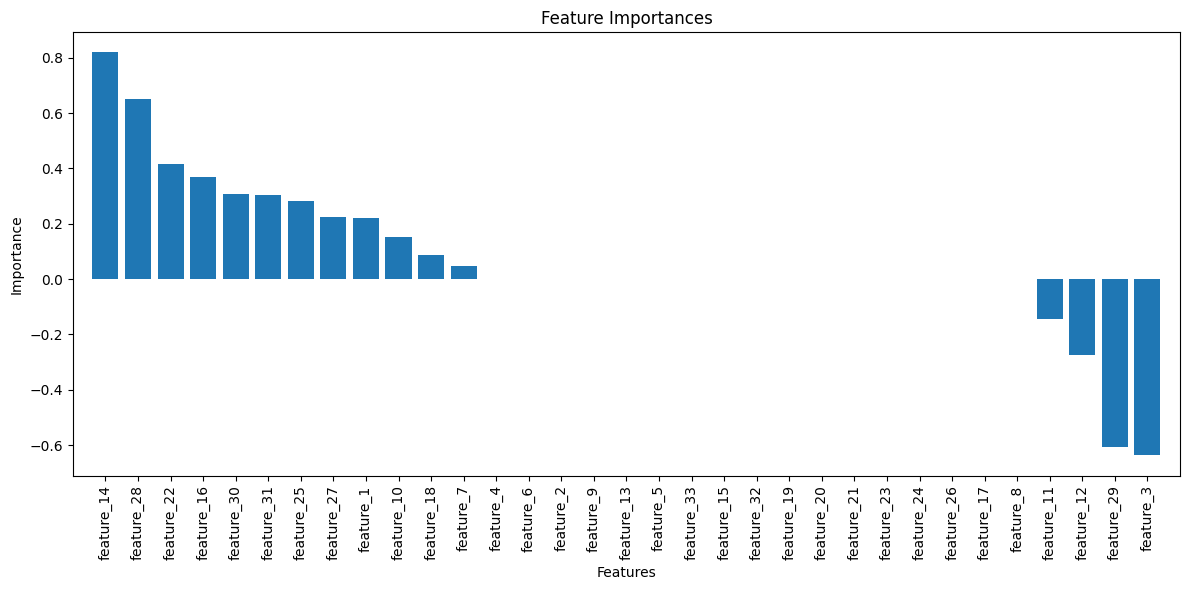

In [50]:
# Получаем названия признаков из best_model
coefficients = best_model.coefficients.toArray()
feature_names = [f"feature_{i}" for i in range(1, len(coefficients) + 1)]

# Функция визуализации важности признаков
def plot_feature_importance(model, feature_names):
    importances = model.coefficients.toArray()
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

# Теперь вызываем функцию
plot_feature_importance(best_model, feature_names)

In [51]:
# Посмотрим гиперпараметры лучшей модели при помощи extractParamMap.
best_model.extractParamMap()

{Param(parent='LogisticRegression_a0c868f53c12', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_a0c868f53c12', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5,
 Param(parent='LogisticRegression_a0c868f53c12', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_a0c868f53c12', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_a0c868f53c12', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_a0c868f53c12', name='labelCol', doc='label column name.'): 'Churn_index',
 Param(parent='LogisticRegression_a0c868f53c12', name='maxBlockSizeInMB', doc='maximum memory in MB

2. Запустите лучшую модель в режиме предсказания на тестовой выборке. Сохраните предсказания в отдельную переменную. Выведите первые несколько строк датафрейма с предсказаниями на экран.

Запуск модели в режиме предсказания выполняется при помощи метода .transform(<тестовая выборка>).

In [52]:
predictions = best_model.transform(test_data)
predictions.show(n=5) 


+-----------+--------------------+--------------------+--------------------+----------+
|Churn_index|            features|       rawPrediction|         probability|prediction|
+-----------+--------------------+--------------------+--------------------+----------+
|        0.0|(33,[0,1,2,3,4,5,...|[0.27089530915223...|[0.56731268884020...|       0.0|
|        0.0|(33,[0,1,2,3,4,5,...|[-0.1967537643018...|[0.45096962912100...|       1.0|
|        0.0|(33,[0,1,2,3,4,5,...|[-0.0623514845751...|[0.48441717698412...|       1.0|
|        0.0|(33,[0,1,2,3,4,5,...|[0.22357389755649...|[0.55566181134496...|       0.0|
|        0.0|(33,[0,1,2,3,4,5,...|[0.24055323001437...|[0.55984997960030...|       0.0|
+-----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



3. Получите метрику качества модели. Для этого примените к объекту evaluator метод .evaluate(<ваш датафрейм с предсказаниями>).



In [53]:
cv_model = crossval.fit(train_data)

In [54]:
roc_auc = evaluator.evaluate(predictions)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.8383


Модель без фичей

[Stage 4168:>                                                       (0 + 1) / 1]

ROC AUC: 0.8172

In [55]:
# Получаем дополнительные метрики
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction")

accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
weighted_precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
weighted_recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

Accuracy: 0.8069
F1 Score: 0.7999
Weighted Precision: 0.7976
Weighted Recall: 0.8069


In [57]:
# Завершение работы сессии Spark
spark.stop()

Модель без фичей

Accuracy: 0.7951

F1 Score: 0.7856

Weighted Precision: 0.7834

Weighted Recall: 0.7951

#10. Обратная связь
Вы ознакомились с возможностями двух мощных библиотек: PySpark SQL для предобработки данных и PySpark ML для машинного обучения.

Поделитесь впечатлениями от работы с новыми библиотеками. В чём они более удобны, чем уже знакомые вам Pandas и Sklearn, а в чём нет.

# Как отправить работу на проверку

Загрузите файл с заданиями, откройте его через Jupyter Notebook в Google Colab. Скачайте файл с датасетом и загрузите его в Colab. Выполните задачи, сохраните изменения: воспользуйтесь опцией Save and Checkpoint из вкладки меню File или кнопкой Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (.ipynb) или ссылку на него.